authorship assignment papers:
 - http://publications.idiap.ch/downloads/papers/2020/Fabien_ICON2020_2020.pdf
 - https://link.springer.com/content/pdf/10.1007%2F978-3-540-30115-8_22.pdf  
 
bert multiclass classsification:
 - https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
   - from: https://www.coursera.org/projects/sentiment-analysis-bert

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from toolz import curry
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

seed = 666

### train/test split

In [11]:
# stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X.index.values, 
    X['label'].values, 
    test_size=0.15, 
    random_state=seed, 
    stratify=X['label'].values
)

In [12]:
X['data_type'] = np.nan * X.shape[0]
X.loc[X_train, 'data_type'] = 'train'
X.loc[X_test, 'data_type'] = 'test'

# X.groupby(['author', 'label', 'data_type']).count()

<AxesSubplot:>

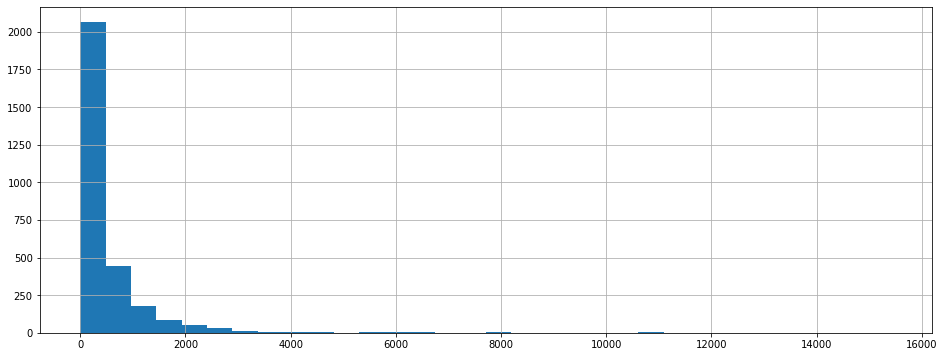

In [13]:
X[X['data_type']=='train']['body'].apply(len).hist(bins=32, figsize=(16,6))

{0.9: 1194, 0.95: 1849, 0.98: 2751, 0.99: 4101}


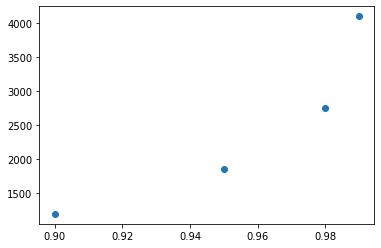

In [14]:
vc = X['body'].apply(len).value_counts().sort_index()
percents = [.9, .95, .98, .99]
cs = map(lambda x: vc.cumsum() < vc.sum() * x, percents)
lens = [vc[~i].index.min() for i in cs]
points = dict(zip(percents, lens))

print(points)
plt.scatter(percents, lens)

# 95% of emails are no longer than 1869 characters

In [15]:
max_len = points[0.95]

# overwrite 512 default tensor setting
max_len = 512

### tokenize

In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [18]:
# partial evaluation (curry) for setting default values
tokenizer_cur = curry(tokenizer.batch_encode_plus)(
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=max_len,
    truncation=True,
    return_tensors='pt'
)

In [19]:
mask_train = X['data_type']=='train'

encoded_data_train = tokenizer_cur(
    X[mask_train]['body'].values
)

In [20]:
mask_test = X['data_type']=='test'

encoded_data_test = tokenizer_cur(
    X[mask_test]['body'].values
)

In [21]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(X[mask_train]['label'].values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(X[mask_test]['label'].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

### bert

In [22]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(LABEL_DICT),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
batch_size = 16  # 3

dataloader_train = DataLoader(
    dataset_train, 
    sampler=RandomSampler(dataset_train), 
    batch_size=batch_size
)
dataloader_test = DataLoader(
    dataset_test, 
    sampler=SequentialSampler(dataset_test), 
    batch_size=batch_size
)

In [24]:
epochs = 2  # 5

optimizer = AdamW(
    model.parameters(),
    lr=1e-5, 
    eps=1e-8
)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

In [25]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in LABEL_DICT.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])} / {len(y_true)}\n')

### training

In [26]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
def input_dict(batch):
    return {
        'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2]
    }

In [50]:
def evaluate(dataloader_test):

    model.eval()
    
    loss_test_total = 0
    predictions, true_tests = [], []
    
    for batch in dataloader_test:

        batch = tuple(b.to(device) for b in batch)
        inputs = input_dict(batch)

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_test_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_tests.append(label_ids)
    
    loss_test_avg = loss_test_total / len(dataloader_test) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_tests = np.concatenate(true_tests, axis=0)
            
    return loss_test_avg, predictions, true_tests

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    progress_bar = tqdm(
        dataloader_train,
        desc='Epoch {:1d}'.format(epoch),
        leave=False,
        disable=False
    )
    
    for batch in progress_bar:
        
        model.zero_grad()
                
        batch = tuple(b.to(device) for b in batch)
        inputs = input_dict(batch)    
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total / len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    test_loss, predictions, true_tests = evaluate(dataloader_test)
    test_f1 = f1_score_func(predictions, true_tests)
    tqdm.write(f'Test loss: {test_loss}')
    tqdm.write(f'F1 Score (Weighted): {test_f1}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/182 [00:00<?, ?it/s]